In [1]:
SEED =0
cores = 16

from numpy.random import seed
seed(SEED)
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from xgboost import plot_importance
from matplotlib import pyplot as plt
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import classification_report
import shap
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve

# version check
import sys
print("python version")
print(sys.version)
import sklearn
print("sklearn version = ", sklearn.__version__)
print("numpy version = ", np.__version__)
print("pandas version =", pd.__version__)

python version
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sklearn version =  0.23.2
numpy version =  1.19.4
pandas version = 1.1.4


In [2]:
df = pd.read_csv("~/proj_ua/data/ua_full.v2.csv")
df = df[df['from']=="cha"]
df2 = df.query('age>=18')
df2['eGFR_ab90'] = np.where(df2['eGFR_ckd']<90, 1, 0)

X = df2.drop(['eGFR_ab90'], axis=1)
y = df2['eGFR_ab90'].astype("int64")
print("total cases = %d" %X.shape[0])
print("total abnormal function of kidney = %d" %sum(y))

total cases = 214397
total abnormal function of kidney = 85151



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
X_train_features = X_train.loc[:, 'male':'he_uro']

print('%d train cases, %d variables' % (X_train_features.shape[0], X_train_features.shape[1]))
print('%d test cases'%X_test.shape[0])

171517 train cases, 11 variables
42880 test cases


In [4]:
#standardization

scaler = StandardScaler()
std_cols=X_train_features.columns[X_train_features.max() > 1].tolist()
std_df=X_train_features[std_cols]
X_train_features[std_cols]=scaler.fit_transform(std_df)

X_train_odds = pd.concat([X_train[['id']], X_train_features], axis=1, join='inner') # for OR calculation in R
X_train_features.describe()

,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro
count,171517.000000,1.715170e+05,1.715170e+05,171517.000000,1.715170e+05,1.715170e+05,1.715170e+05,1.715170e+05,1.715170e+05,1.715170e+05,1.715170e+05
mean,0.425270,1.944581e-16,-1.020760e-16,0.020424,1.351844e-14,-4.598392e-18,3.198161e-17,-1.864213e-17,2.535330e-17,-3.629001e-17,1.706791e-17
std,0.494385,1.000003e+00,1.000003e+00,0.141445,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,0.000000,-1.844653e+00,-1.466638e+00,0.000000,-1.721120e+00,-4.310575e-01,-2.444696e-01,-3.033638e-01,-1.178484e-01,-6.145566e-01,-5.279493e-01
25%,0.000000,-7.590584e-01,-8.563884e-01,0.000000,-1.089027e+00,-4.310575e-01,-2.444696e-01,-3.033638e-01,-1.178484e-01,-6.145566e-01,-5.279493e-01
50%,0.000000,-1.843321e-01,-2.461391e-01,0.000000,1.751591e-01,-4.310575e-01,-2.444696e-01,-3.033638e-01,-1.178484e-01,-6.145566e-01,-5.279493e-01
75%,1.000000,7.096868e-01,9.743594e-01,0.000000,8.072522e-01,-4.310575e-01,-2.444696e-01,-3.033638e-01,-1.178484e-01,1.728377e-01,-5.279493e-01
max,1.000000,3.902611e+00,3.415357e+00,1.000000,1.439345e+00,6.038803e+00,5.763308e+00,7.184555e+00,1.556817e+01,2.535021e+00,9.451143e+00


In [6]:
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=8, random_state=SEED)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=cores)
    return scores

#model is ua_cha90.v1
model = XGBClassifier(colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=8, 
                          min_child_weight=1, n_estimators=1000, objective="binary:logistic",
                          reg_alpha=1, reg_lambda=6, scale_pos_weight=2, subsample=0.6, 
                          nthread=6, random_state=SEED).fit(X_train_features, y_train)
scores = evaluate_model(X_train_features, y_train, model)
print('Mean accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean accuracy: 0.819 (0.002)


<Figure size 432x288 with 0 Axes>

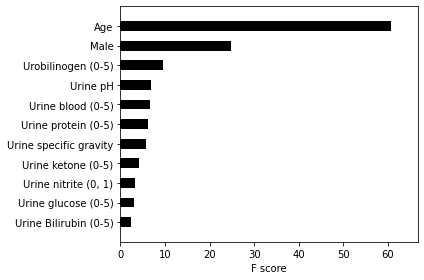

In [7]:
# feature_importances

df_imp = pd.DataFrame({'imp':model.feature_importances_}, index = model.get_booster().feature_names)
df_imp = df_imp[df_imp.imp > 0].sort_values('imp', ascending=False).copy()

feat_names = model.get_booster().feature_names
df_feat_names = pd.DataFrame(feat_names, index=feat_names)
names = pd.read_csv('/home/danssa/KNHANES_eGFR/knhanes_urine_explain.csv', index_col ='var')
model.get_booster().feature_names = names.loc[df_feat_names.index,'name'].tolist()

#plt.rcParams["figure.figsize"] = (4,6)
#plt.rcParams["font.size"] = 15
plt.figure().clear()
g = plot_importance(model.get_booster(), importance_type='gain', show_values=False,
                    height = 0.5, title=None, ylabel=None, grid=False,
                    color='black').get_figure()
plt.tight_layout()
plt.show()
#g.savefig('/home/danssa/KNHANES_eGFR/knhanes_eGFR_ML.v8/knhanes_eGFR_xgboost_importance_FeatureReduction_v8.1.pdf')

model.get_booster().feature_names = feat_names #recover model feature names

In [8]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_train_prob = model.predict_proba(X_train_features)
y_train_prob2 = y_train_prob[:,1]

# calculate roc curves
t_fpr, t_tpr, t_thresholds = roc_curve(y_train, y_train_prob2)
# get the best threshold
t_J = t_tpr - t_fpr
t_ix = argmax(t_J)
train_best_thresh = t_thresholds[t_ix]
print('train Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (train_best_thresh, t_tpr[t_ix], 1-t_fpr[t_ix], t_J[t_ix]))

train Best Threshold=0.565264, sensitivity = 0.767, specificity = 0.724, J=0.491


              id  eGFR_ab    eGFR_ckd  eGFR_ab90   pred type
232609  10392100        1   54.856603          1   True   TP
146193  11634428        0   78.962061          1   True   TP
238763  11513043        0  110.266302          0  False   TN
69902   10538122        0   63.521403          1   True   TP
125344  11349981        0   94.477040          0  False   TN


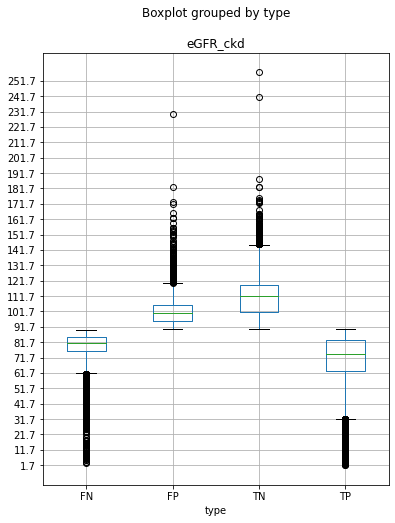

In [10]:
#ploting FN, FP eGFR

train_prob_pred = (model.predict_proba(X_train_features)[:,1] >= train_best_thresh).astype(bool)

df_train = pd.DataFrame(y_train)
df_train['pred'] = train_prob_pred

conditions = [
    (df_train['eGFR_ab90'] == 1) & (df_train['pred'] == 1),
    (df_train['eGFR_ab90'] == 1) & (df_train['pred'] == 0),
    (df_train['eGFR_ab90'] == 0) & (df_train['pred'] == 1),
    (df_train['eGFR_ab90'] == 0) & (df_train['pred'] == 0)
]

vals = ['TP', 'FN', 'FP', 'TN']

df_train['type'] = np.select(conditions, vals)

df_train_t1 = X_train.loc[:,'id':'eGFR_ckd'].merge(df_train, right_index=True, left_index=True, how='right')
print(df_train_t1.head())

plt.rcParams["figure.figsize"] = (6,8)
df_train_t1.boxplot('eGFR_ckd', by='type')
plt.yticks(np.arange(min(df_train_t1['eGFR_ckd']), max(df_train_t1['eGFR_ckd'])+1, 10))
plt.show()

In [11]:
#SHAP value 

shap.initjs()
print(shap.__version__)

names = pd.read_csv('/home/danssa/KNHANES_eGFR/knhanes_urine_explain.csv', index_col='var')
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_features)
meaning_dict = names.to_dict()['name']

0.37.0


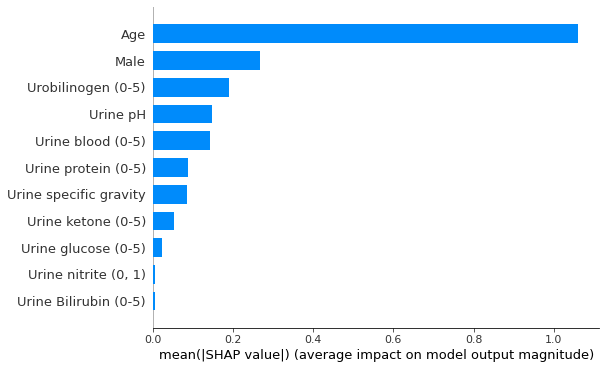

In [12]:
shap.summary_plot(shap_values, X_train_features.rename(columns=meaning_dict), plot_type='bar')

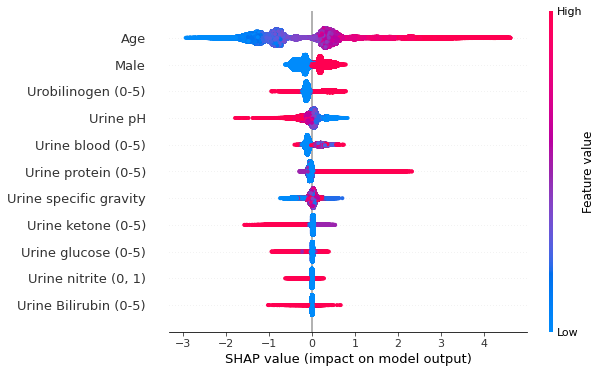

In [13]:
shap.summary_plot(shap_values, X_train_features.rename(columns=meaning_dict))

<Figure size 432x576 with 0 Axes>

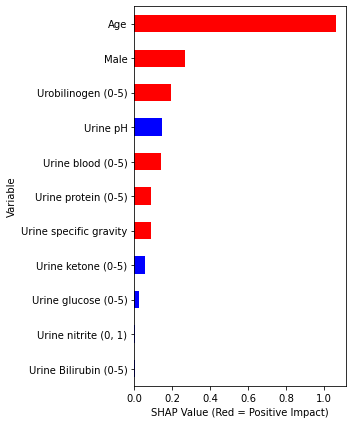

In [14]:
plt.figure().clear()
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

ABS_SHAP(shap_values, X_train_features.rename(columns=meaning_dict))
plt.tight_layout()
plt.show()

In [15]:
X_test_features = X_test.loc[:, 'male':'he_uro']
std_df=X_test_features[std_cols]
X_test_features[std_cols]=scaler.transform(std_df)

X_test_odds = pd.concat([X_test[['id']], X_test_features], axis=1, join='inner') # for OR calculation in R

y_pred = model.predict(X_test_features)
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['abnormal', 'normal']))


Classification Report

              precision    recall  f1-score   support

    abnormal       0.84      0.65      0.73     25850
      normal       0.61      0.81      0.69     17030

    accuracy                           0.71     42880
   macro avg       0.72      0.73      0.71     42880
weighted avg       0.75      0.71      0.72     42880



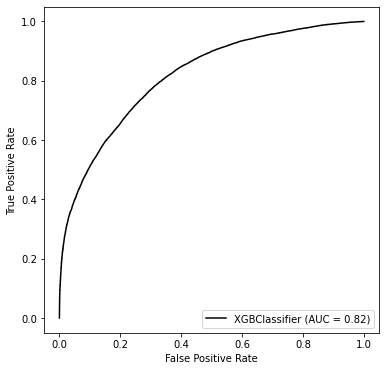

In [16]:
plt.rcParams["figure.figsize"] = (6,6)
model_roc = plot_roc_curve(model, X_test_features, y_test, color='black')
plt.show()

In [17]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = model.predict_proba(X_test_features)
y_prob2 = y_prob[:,1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob2)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]

print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (model.predict_proba(X_test_features)[:,1] >= best_thresh).astype(bool)
print('\nClassification Report\n')
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

Best Threshold=0.558170, sensitivity = 0.764, specificity = 0.707, J=0.471

Classification Report

              precision    recall  f1-score   support

      normal       0.82      0.71      0.76     25850
    abnormal       0.63      0.76      0.69     17030

    accuracy                           0.73     42880
   macro avg       0.73      0.74      0.73     42880
weighted avg       0.75      0.73      0.73     42880



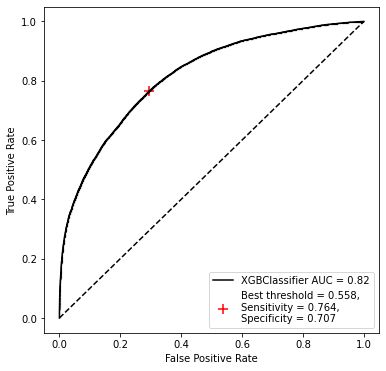

In [18]:
#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="XGBClassifier AUC = %.2f" % roc_auc_score(y_test, y_prob2))
plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r', 
            label='Best threshold = %.3f, \nSensitivity = %.3f, \nSpecificity = %.3f' % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

In [19]:
#precision, recall, thresholds

# calculate roc curves
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob2)

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.361022, F-Score=0.694


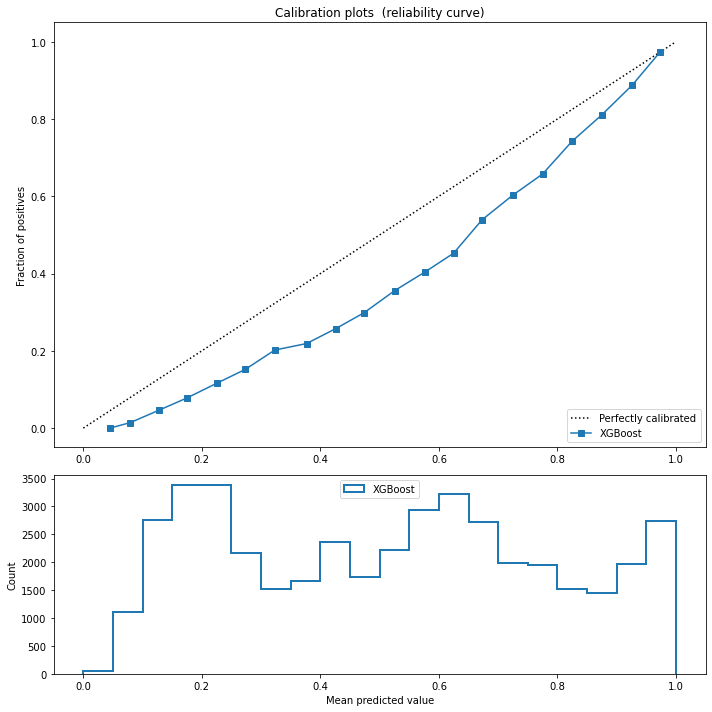

In [20]:
from sklearn.calibration import calibration_curve
# Create classifiers
xgb = model

# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(xgb, 'XGBoost')]:
    clf.fit(X_test_features, y_test)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test_features)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test_features)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=20)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=20, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()